In [1]:
import os
import json
import pandas as pd
import torch
import torch.nn as nn


from config import get_config
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy


In [ ]:
cfg=get_config()
print(cfg)

[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Detected dataset size: 1000
[INFO] model tag: EfficientNet, backbone: efficientnet


namespace(model_tag='EfficientNet',
          backbone='efficientnet',
          batch_size=512,
          epochs=50,
          learning_rate=0.0001,
          patience=5,
          input_shape=(1, 32, 32),
          global_max=121.79151153564453,
          dataset_root_dir='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled',
          train_csv='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled/train_files.csv',
          val_csv='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled/val_files.csv',
          test_csv='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_

In [3]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000


In [4]:
# Set seed, device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [5]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 2
[INFO] Length of validation dataloader: 1
[INFO] Length of test dataloader: 1


In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

MultiHeadClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (con

In [7]:
criterion = {
    'energy_loss_output': nn.BCELoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCELoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [8]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [9]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/training_summary.json


In [10]:
for epoch in range(start_epoch, cfg.epochs):
    print(f"[INFO] Epoch {epoch+1}/{cfg.epochs}")
    train_metrics={}
    train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
    (train_loss_list,
    train_loss_energy_list,
    train_loss_alpha_list,
    train_loss_q0_list,
    train_acc_list,
    train_acc_energy_list,
    train_acc_alpha_list,
    train_acc_q0_list
    ) = update_train_logs(
        train_metrics,
        train_loss_list,
        train_loss_energy_list,
        train_loss_alpha_list,
        train_loss_q0_list,
        train_acc_list,
        train_acc_energy_list,
        train_acc_alpha_list,
        train_acc_q0_list
    )
    val_metrics = evaluate(val_loader, model, criterion, device)
    (val_loss_list,
    val_loss_energy_list,
    val_loss_alpha_list,
    val_loss_q0_list,
    val_acc_list,
    val_acc_energy_list,
    val_acc_alpha_list,
    val_acc_q0_list,
    ) = update_val_logs(
        val_metrics,
        val_loss_list,
        val_loss_energy_list,
        val_loss_alpha_list,
        val_loss_q0_list,
        val_acc_list,
        val_acc_energy_list,
        val_acc_alpha_list,
        val_acc_q0_list,
    )
    print(f"[INFO] Epoch {epoch+1}: Energy Acc ={val_metrics['energy']['accuracy']:.4f}, αs Acc = {val_metrics['alpha']['accuracy']:.4f}, Q0 Acc = {val_metrics['q0']['accuracy']:.4f}, Total Acc = {val_metrics['accuracy']:.4f}")
    print(f"[INFO] Epoch {epoch+1}: Energy Loss ={val_metrics['loss_energy']:.4f}, αs Loss = {val_metrics['loss_alpha']:.4f}, Q0 Loss = {val_metrics['loss_q0']:.4f}, Total Loss = {val_metrics['loss']:.4f}")
    
    all_epoch_metrics=record_and_save_epoch(epoch, train_metrics, val_metrics, all_epoch_metrics, cfg.output_dir)
    
    save_epoch_checkpoint(
        epoch=epoch,
        model=model,
        optimizer=optimizer,
        metrics=val_metrics,
        output_dir=cfg.output_dir
    )

    best_acc, best_metrics, best_epoch, early_stop_counter, should_stop = check_early_stopping(
        best_acc=best_acc,
        best_metrics=best_metrics,
        early_stop_counter=early_stop_counter,
        best_epoch=best_epoch,
        model=model,
        optimizer=optimizer,
        val_metrics=val_metrics,
        output_dir=cfg.output_dir,
        patience=cfg.patience,
        epoch=epoch
    )
    
    if should_stop:
        break
    
    print("="*150)
    

[INFO] Epoch 1/50


[INFO] Epoch 1: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 1: Energy Loss =0.6900, αs Loss = 1.0986, Q0 Loss = 1.3863, Total Loss = 3.1749
[INFO] Epoch 1: Saving metrics to disk
[INFO] Epoch 1: 💾 Checkpoint saved: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/checkpoint_epoch_1.pth
✅ Best model saved at epoch 1 with total accuracy: 0.0833
[INFO] Epoch 2/50


[INFO] Epoch 2: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 2: Energy Loss =0.6902, αs Loss = 1.0986, Q0 Loss = 1.3863, Total Loss = 3.1752
[INFO] Epoch 2: Saving metrics to disk


[INFO] Epoch 2: 💾 Checkpoint saved: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/checkpoint_epoch_2.pth
⏳ No improvement. Early stop counter: 1/5
[INFO] Epoch 3/50


[INFO] Epoch 3: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 3: Energy Loss =0.6893, αs Loss = 1.0986, Q0 Loss = 1.3863, Total Loss = 3.1743
[INFO] Epoch 3: Saving metrics to disk


[INFO] Epoch 3: 💾 Checkpoint saved: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/checkpoint_epoch_3.pth
⏳ No improvement. Early stop counter: 2/5
[INFO] Epoch 4/50


[INFO] Epoch 4: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 4: Energy Loss =0.6873, αs Loss = 1.0986, Q0 Loss = 1.3863, Total Loss = 3.1722
[INFO] Epoch 4: Saving metrics to disk


[INFO] Epoch 4: 💾 Checkpoint saved: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/checkpoint_epoch_4.pth
⏳ No improvement. Early stop counter: 3/5
[INFO] Epoch 5/50


[INFO] Epoch 5: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 5: Energy Loss =0.6837, αs Loss = 1.0986, Q0 Loss = 1.3863, Total Loss = 3.1687
[INFO] Epoch 5: Saving metrics to disk


[INFO] Epoch 5: 💾 Checkpoint saved: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/checkpoint_epoch_5.pth
⏳ No improvement. Early stop counter: 4/5
[INFO] Epoch 6/50


[INFO] Epoch 6: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 6: Energy Loss =0.6795, αs Loss = 1.0986, Q0 Loss = 1.3863, Total Loss = 3.1645
[INFO] Epoch 6: Saving metrics to disk


[INFO] Epoch 6: 💾 Checkpoint saved: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/checkpoint_epoch_6.pth
⏳ No improvement. Early stop counter: 5/5
🛑 Early stopping triggered at epoch 6. Best was at epoch 1.


In [11]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/training_summary.json

🏁 Best Model @ Epoch 1
Total Accuracy: 0.0833

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286

🔹 ALPHA Task
  Accuracy : 0.3333
  Precision: 0.1111
  Recall   : 0.3333
  F1-Score : 0.1667

🔹 Q0 Task
  Accuracy : 0.2500
  Precision: 0.0625
  Recall   : 0.2500
  F1-Score : 0.1000


📊 Plots saved to:
 - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/loss_accuracy_plot.png
 - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/loss_accuracy_plot.pdf


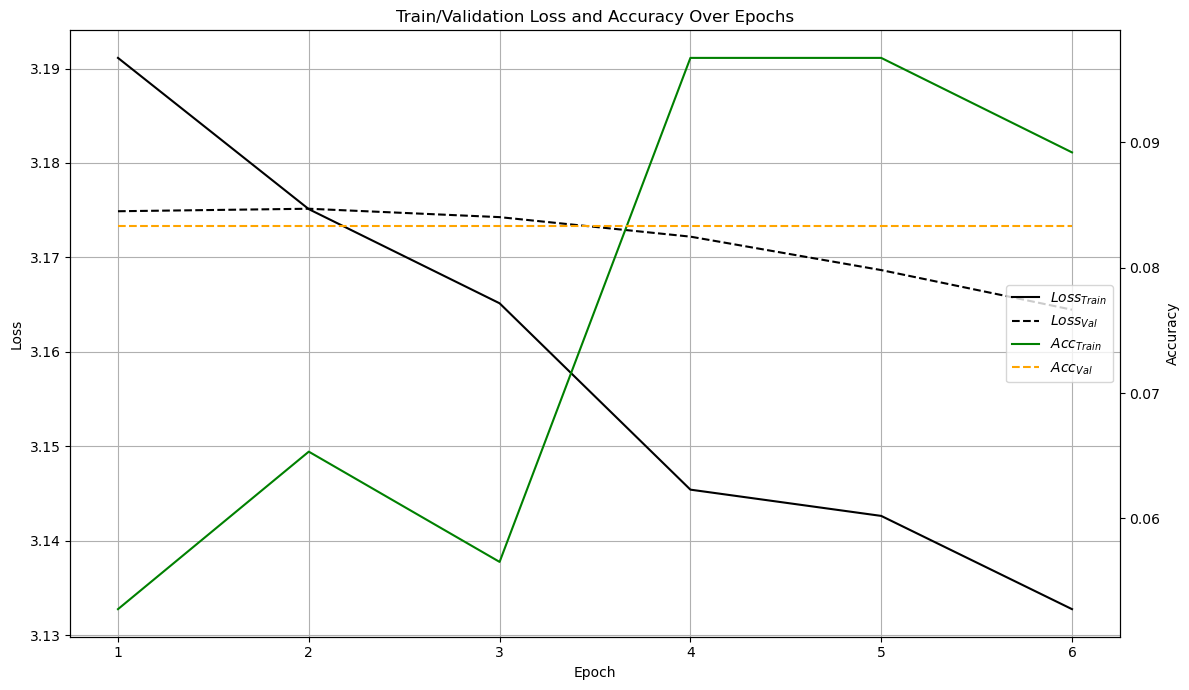

📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/train_loss_and_accuracy_per_epoch_plot.pdf


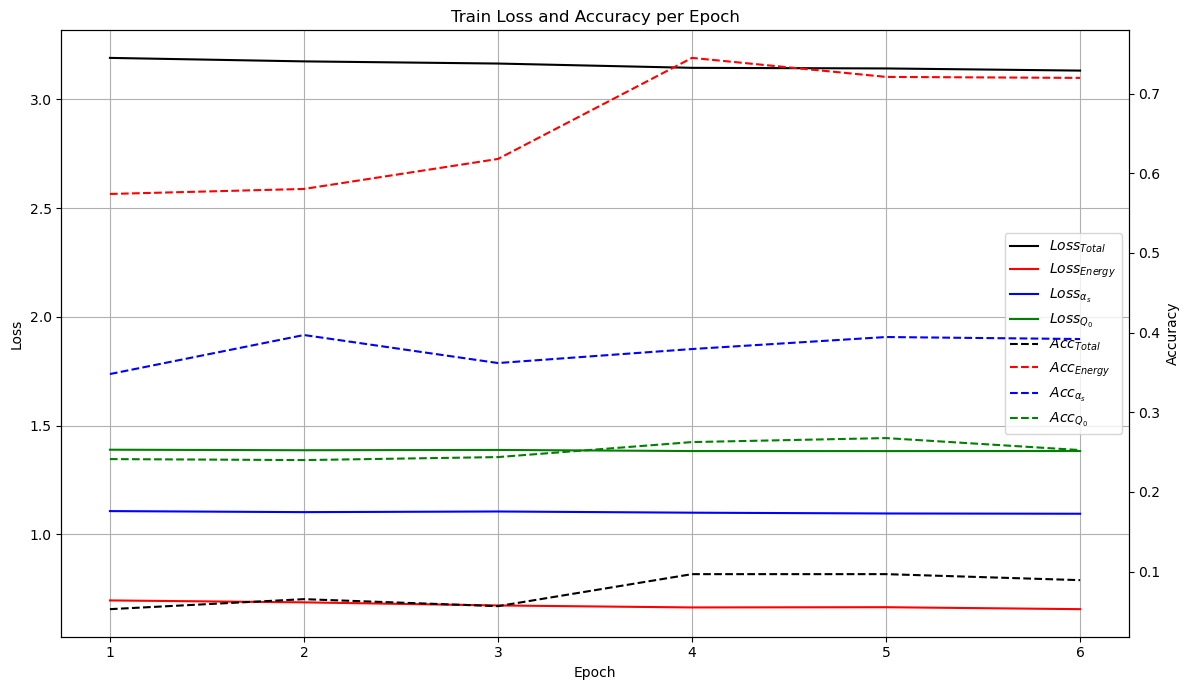

📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/validation_loss_and_accuracy_per_epoch_plot.pdf


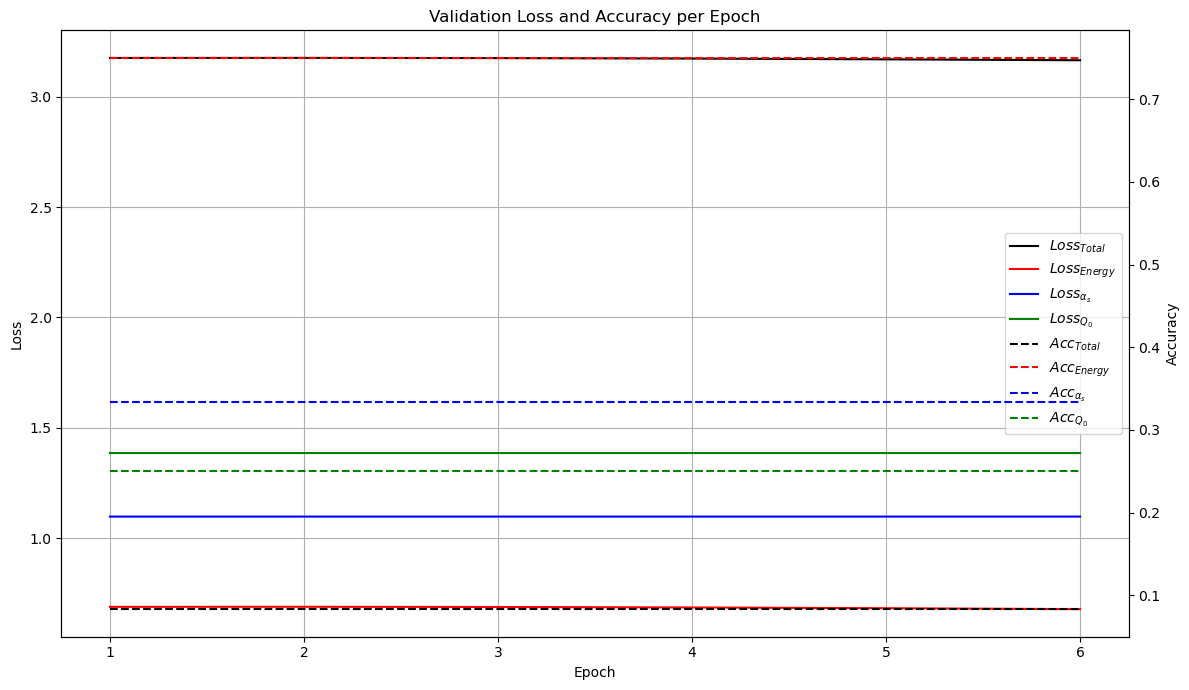

In [12]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")

In [13]:
print("Training Loss Lists:")
print(f"train_loss_list: {train_loss_list}")
print(f"train_loss_energy_list: {train_loss_energy_list}")
print(f"train_loss_alpha_list: {train_loss_alpha_list}")
print(f"train_loss_q0_list: {train_loss_q0_list}")
print("Training Accuracy Lists:")
print(f"train_acc_list: {train_acc_list}")
print(f"train_acc_energy_list: {train_acc_energy_list}")
print(f"train_acc_alpha_list: {train_acc_alpha_list}")
print(f"train_acc_q0_list: {train_acc_q0_list}")

print("Lengths of Training Loss Lists:")
print(f"Length of train_loss_list: {len(train_loss_list)}")
print(f"Length of train_loss_energy_list: {len(train_loss_energy_list)}")
print(f"Length of train_loss_alpha_list: {len(train_loss_alpha_list)}")
print(f"Length of train_loss_q0_list: {len(train_loss_q0_list)}")
print("Lengths of Training Accuracy Lists:")
print(f"Length of train_acc_list: {len(train_acc_list)}")
print(f"Length of train_acc_energy_list: {len(train_acc_energy_list)}")
print(f"Length of train_acc_alpha_list: {len(train_acc_alpha_list)}")
print(f"Length of train_acc_q0_list: {len(train_acc_q0_list)}")


Training Loss Lists:
train_loss_list: [3.19113290309906, 3.175112009048462, 3.165138363838196, 3.1453975439071655, 3.1426159143447876, 3.132737636566162]
train_loss_energy_list: [0.695653885602951, 0.6868261396884918, 0.6724973022937775, 0.6634133458137512, 0.6644611358642578, 0.6554986238479614]
train_loss_alpha_list: [1.1065739393234253, 1.1017975807189941, 1.1047701239585876, 1.0992168188095093, 1.0955989956855774, 1.0943601727485657]
train_loss_q0_list: [1.3889050483703613, 1.3864883184432983, 1.3878709077835083, 1.3827674388885498, 1.3825558423995972, 1.382878839969635]
Training Accuracy Lists:
train_acc_list: [0.052763819095477386, 0.06532663316582915, 0.056532663316582916, 0.09673366834170855, 0.09673366834170855, 0.08919597989949749]
train_acc_energy_list: [0.5741206030150754, 0.5804020100502513, 0.6180904522613065, 0.7449748743718593, 0.7211055276381909, 0.7198492462311558]
train_acc_alpha_list: [0.3479899497487437, 0.3969849246231156, 0.36180904522613067, 0.3793969849246231, 

In [14]:
print("Validation Loss Lists:")
print(f"val_loss_list: {val_loss_list}")
print(f"val_loss_energy_list: {val_loss_energy_list}")
print(f"val_loss_alpha_list: {val_loss_alpha_list}")
print(f"val_loss_q0_list: {val_loss_q0_list}")
print("\nValidation Accuracy Lists:")
print(f"val_acc_list: {val_acc_list}")
print(f"val_acc_energy_list: {val_acc_energy_list}")
print(f"val_acc_alpha_list: {val_acc_alpha_list}")
print(f"val_acc_q0_list: {val_acc_q0_list}")

print("\nLengths of Validation Loss Lists:")
print(f"Length of val_loss_list: {len(val_loss_list)}")
print(f"Length of val_loss_energy_list: {len(val_loss_energy_list)}")
print(f"Length of val_loss_alpha_list: {len(val_loss_alpha_list)}")
print(f"Length of val_loss_q0_list: {len(val_loss_q0_list)}")
print("\nLengths of Validation Accuracy Lists:")
print(f"Length of val_acc_list: {len(val_acc_list)}")
print(f"Length of val_acc_energy_list: {len(val_acc_energy_list)}")
print(f"Length of val_acc_alpha_list: {len(val_acc_alpha_list)}")
print(f"Length of val_acc_q0_list: {len(val_acc_q0_list)}")


Validation Loss Lists:
val_loss_list: [3.174889087677002, 3.175154209136963, 3.1742653846740723, 3.1721982955932617, 3.168656349182129, 3.1644577980041504]
val_loss_energy_list: [0.6899642944335938, 0.690229594707489, 0.6893417239189148, 0.6872720718383789, 0.6837250590324402, 0.6795204877853394]
val_loss_alpha_list: [1.0986188650131226, 1.098617672920227, 1.0986168384552002, 1.0986170768737793, 1.0986207723617554, 1.0986262559890747]
val_loss_q0_list: [1.386305809020996, 1.3863071203231812, 1.386306881904602, 1.386309027671814, 1.3863104581832886, 1.3863111734390259]

Validation Accuracy Lists:
val_acc_list: [0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333]
val_acc_energy_list: [0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
val_acc_alpha_list: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
val_acc_q0_list: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

Le